# helper functions

In [1]:
%%time
%run theory_basics.ipynb
from IPython.display import clear_output
clear_output()

CPU times: user 25.1 s, sys: 47.5 s, total: 1min 12s
Wall time: 12 s


In [2]:
from scipy.ndimage import zoom
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [3]:
def calculate_frequencies(indices, dt, signal_length):
    """Calculate and interpolate frequencies"""
    time_periods = np.diff(indices) * dt
    frequencies = 1 / time_periods
    midpoints = indices[:-1] + np.diff(indices) / 2
    f = interp1d(midpoints, frequencies, kind='linear', fill_value='extrapolate', bounds_error=False)
    return f(np.arange(signal_length))

def infer_frequencies(x, dt=1/N):
    """
    Assign current frequency at each timestep.
    
    Parameters:
       x(numpy.ndarray): input, continuous signal
       dt(float): time difference between each subsequent sample (1/Fs)
       
    Returns:
       numpy.ndarray: current frequency at each timestep
    """
    # Detect peaks and troughs
    peak_indices = find_peaks(x)[0]
    trough_indices = find_peaks(-x)[0]

    # Calculate frequencies using peaks and troughs independently
    peak_freqs = calculate_frequencies(peak_indices, dt, len(x))
    trough_freqs = calculate_frequencies(trough_indices, dt, len(x))

    # Combine the frequencies calculated from peaks and troughs
    combined_freqs = (peak_freqs + trough_freqs) / 2

    return combined_freqs

In [4]:
def get_angle(f):
    return np.angle(np.fft.fft(f)[1])

def get_angles(F):
    return np.angle(np.fft.fft(F, axis=1)[:, 1])

def get_amps(F):
    return np.abs(np.fft.fft(F, axis=1)[:, 1])

In [5]:
def to_theta(x):
    return ((x + np.pi) % (2*np.pi)) - np.pi

In [6]:
def mean_angle(amps, angs):
    s = sum(amps)
    return np.angle(np.sum([
        amp * np.exp(1j*ang)
        for amp, ang in zip(amps, angs)
    ], axis=0))

In [7]:
def get_dx(X, w, i, f_I, phi, u, alpha, theta, t, delay_i, T, dt, train=True):
    I_in = f_I(w, X[i - delay_i])
    return (-X[i - 1] + phi(int(train) * u(t[i] + theta, T) + I_in)) * dt * alpha

def f_I_conv_circ_fft(signal, ker):
    return np.real(np.fft.ifft(np.fft.fft(signal) * np.fft.fft(ker)))

In [8]:
def plot_system_segment(start, end, X, W, t):
    plt.figure(figsize=(12, 5))
    gs = plt.GridSpec(1, 4, width_ratios=[1, 2, 2, 0.1])
    ax1 = plt.subplot(gs[0, 0])
    ax1.imshow(X[start:end], extent=[0, N/(end-start)*(t[end]-t[start]), t[end], t[start]])
    ax1.set_ylabel('time (s)')
    ax1.set_xlabel('x')
    ax1.set_title(r'$r(x, t)$')
    ax2 = plt.subplot(gs[0, 1])
    X_fft = np.fft.fft(X, axis=1)[:, 1]
    ax2.scatter(X_fft.real[start:end], X_fft.imag[start:end], c=t[start:end], s=1)
    ax2.set_xlabel('Re')
    ax2.set_ylabel('Im')
    ax2.set_title(r'$\mathcal{F}_{x}[r](\xi=\frac{1}{T}, t)$')
    ax3 = plt.subplot(gs[0, 2])
    W_fft = np.fft.fft(W, axis=1)[:, 1]
    w_fft_max_h = np.abs(W_fft.real[start:end]).max()+5
    w_fft_max_v = np.abs(W_fft.imag[start:end]).max()+5
    w_fft_max = max(w_fft_max_h, w_fft_max_v)
    scatter = ax3.scatter(W_fft.real[start:end], W_fft.imag[start:end], c=t[start:end], s=1)
    ax3.set_xlim(-w_fft_max, w_fft_max)
    ax3.set_ylim(-w_fft_max, w_fft_max)
    ax3.set_xlabel('Re')
    ax3.set_ylabel('Im')
    ax3.set_title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
    ax_colorbar = plt.subplot(gs[0, -1])
    cbar = plt.colorbar(scatter, cax=ax_colorbar)
    cbar.set_label('time (s)')
    plt.tight_layout()
    plt.show()

# replay

In [14]:
simulation_duration = 150.5 * T
t = np.arange(0, simulation_duration, dt)

lmbda = 20

tau_x = 1 / 100
alpha = 1 / tau_x

tau_a = T / 3
delay_i = round(tau_a / dt)

tau_w = 50
beta = 1 / tau_w
#beta = 0

In [15]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True)

CPU times: user 5.68 s, sys: 5.88 ms, total: 5.69 s
Wall time: 5.69 s


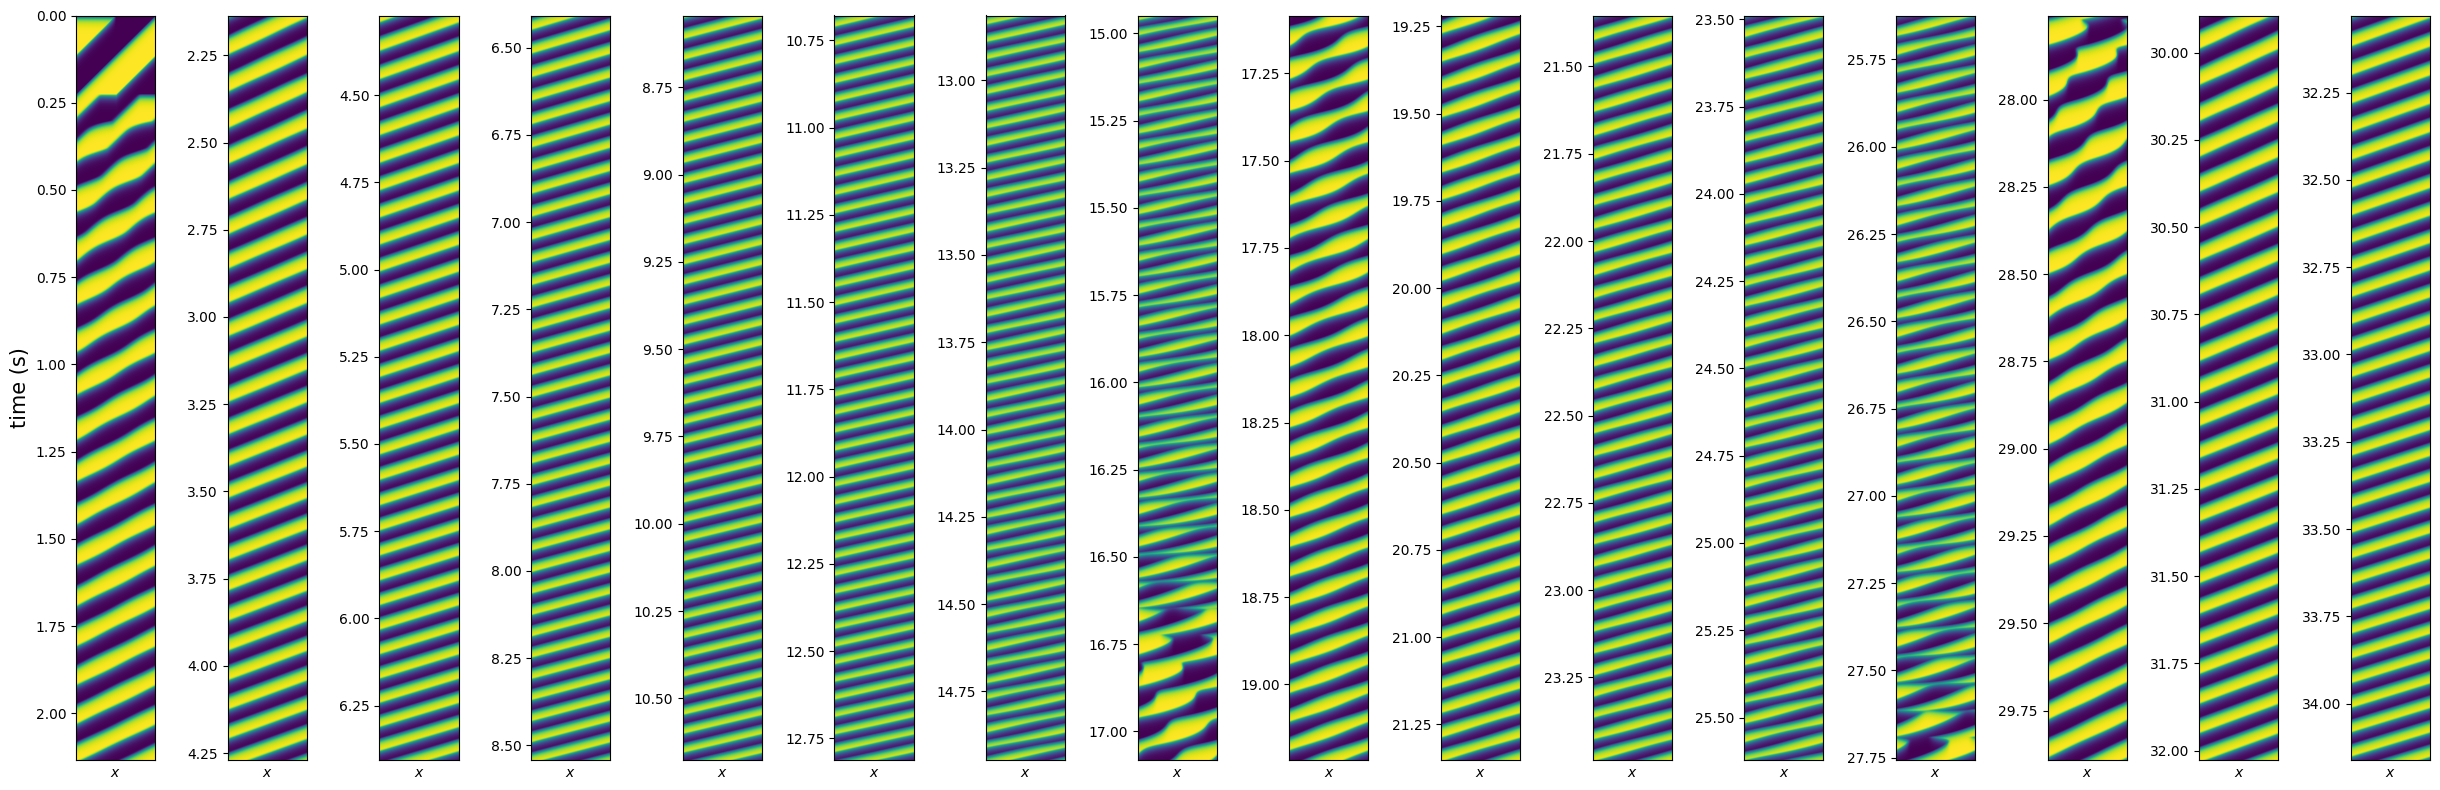

In [16]:
plot_activity(X, t, bins=16, cutoff_div=None)

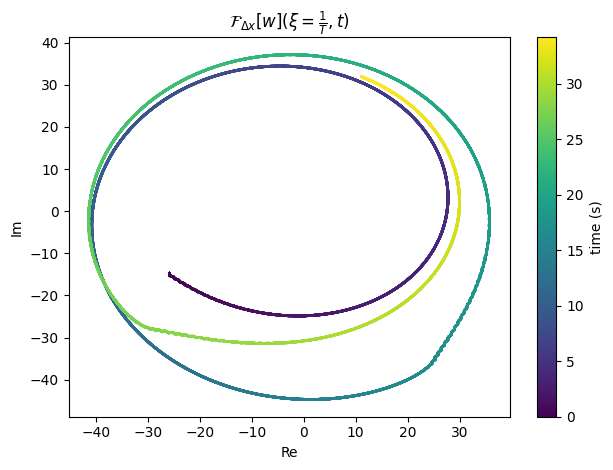

In [17]:
W_fft = np.fft.fft(W, axis=1)[:, 1]
scatter = plt.scatter(W_fft.real, W_fft.imag, c=t, s=1)
plt.title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
plt.xlabel('Re')
plt.ylabel('Im')
cbar = plt.colorbar(scatter)
cbar.set_label('time (s)')
plt.tight_layout()

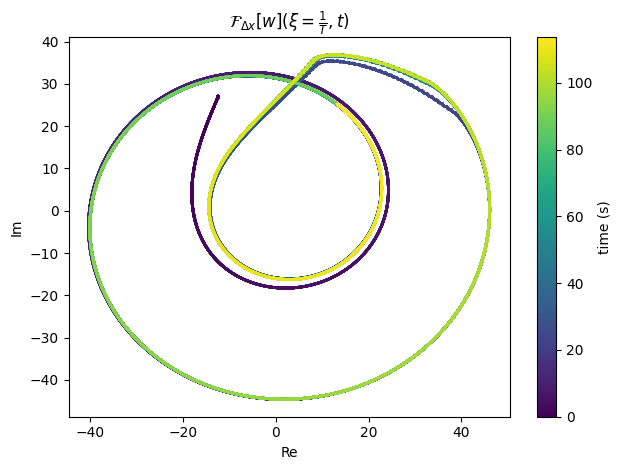

In [40]:
W_fft = np.fft.fft(W, axis=1)[:, 1]
scatter = plt.scatter(W_fft.real, W_fft.imag, c=t, s=1)
plt.title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
plt.xlabel('Re')
plt.ylabel('Im')
cbar = plt.colorbar(scatter)
cbar.set_label('time (s)')
plt.tight_layout()

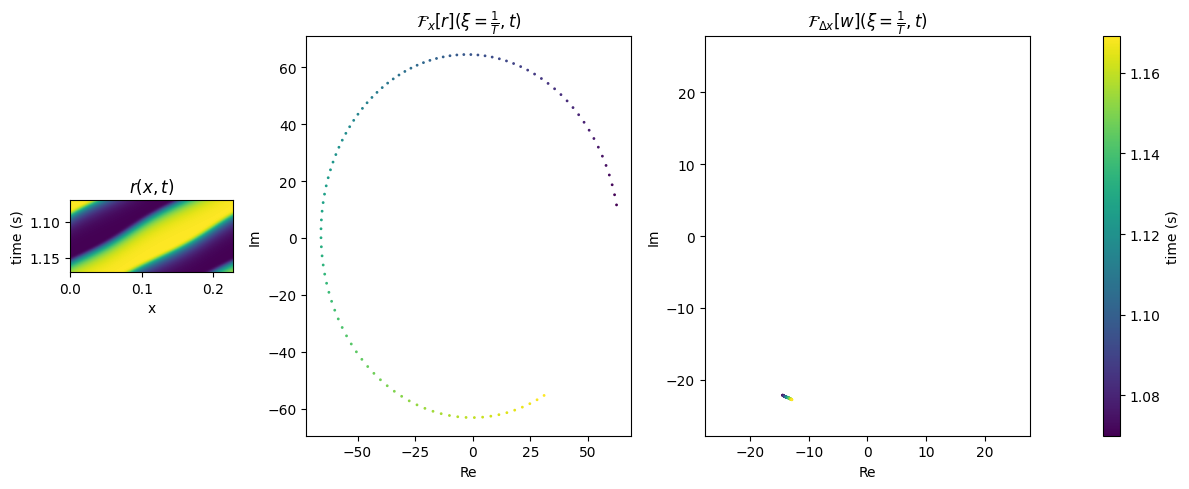

In [18]:
plot_system_segment(1070, 1170, X, W, t)

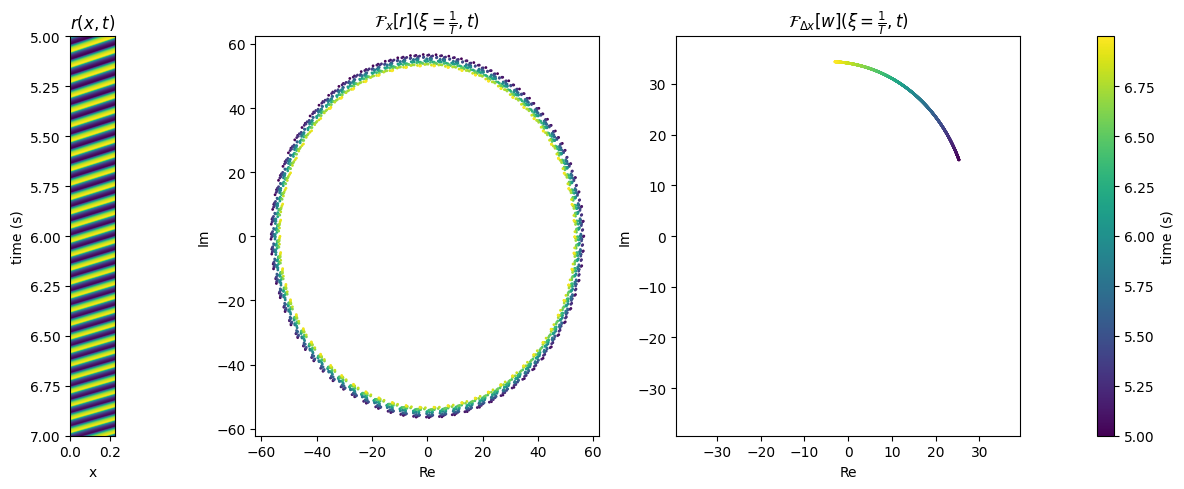

In [19]:
plot_system_segment(5000, 7000, X, W, t)

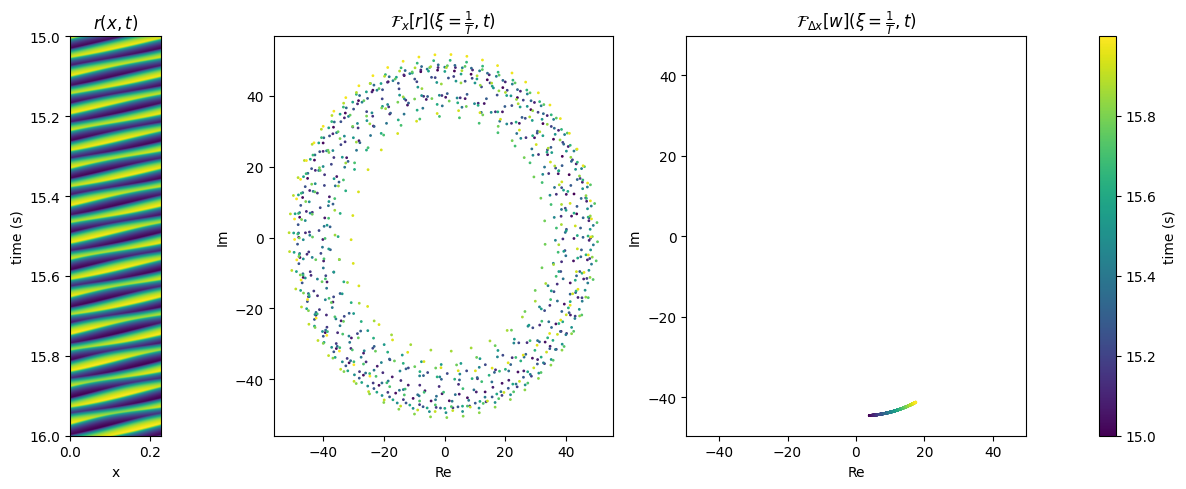

In [20]:
plot_system_segment(15000, 16000, X, W, t)

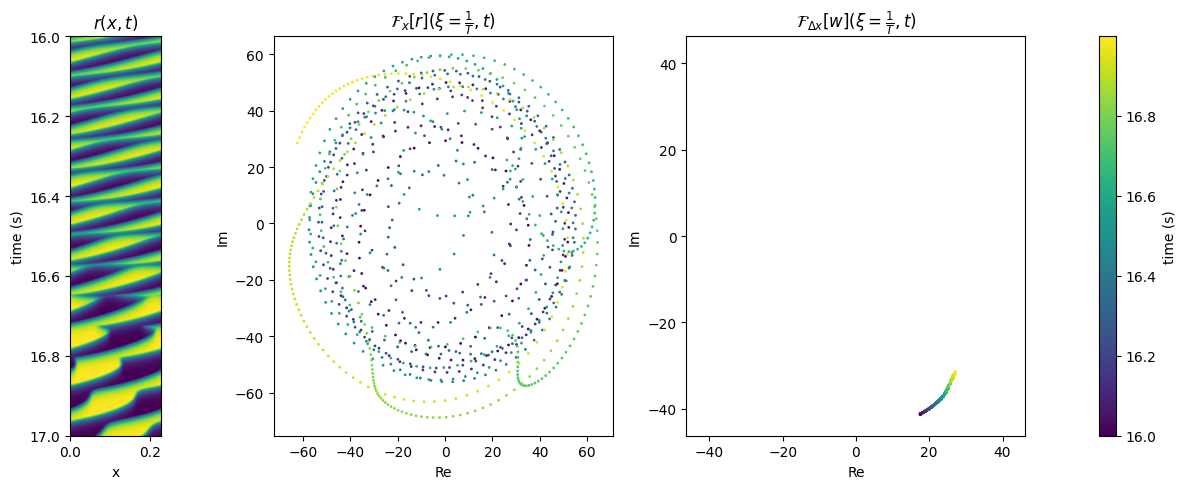

In [21]:
plot_system_segment(16000, 17000, X, W, t)

# reverse replay

In [44]:
tau_a = T / 9
delay_i = round(tau_a / dt)

In [45]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True)

CPU times: user 5.62 s, sys: 4.12 ms, total: 5.63 s
Wall time: 5.63 s


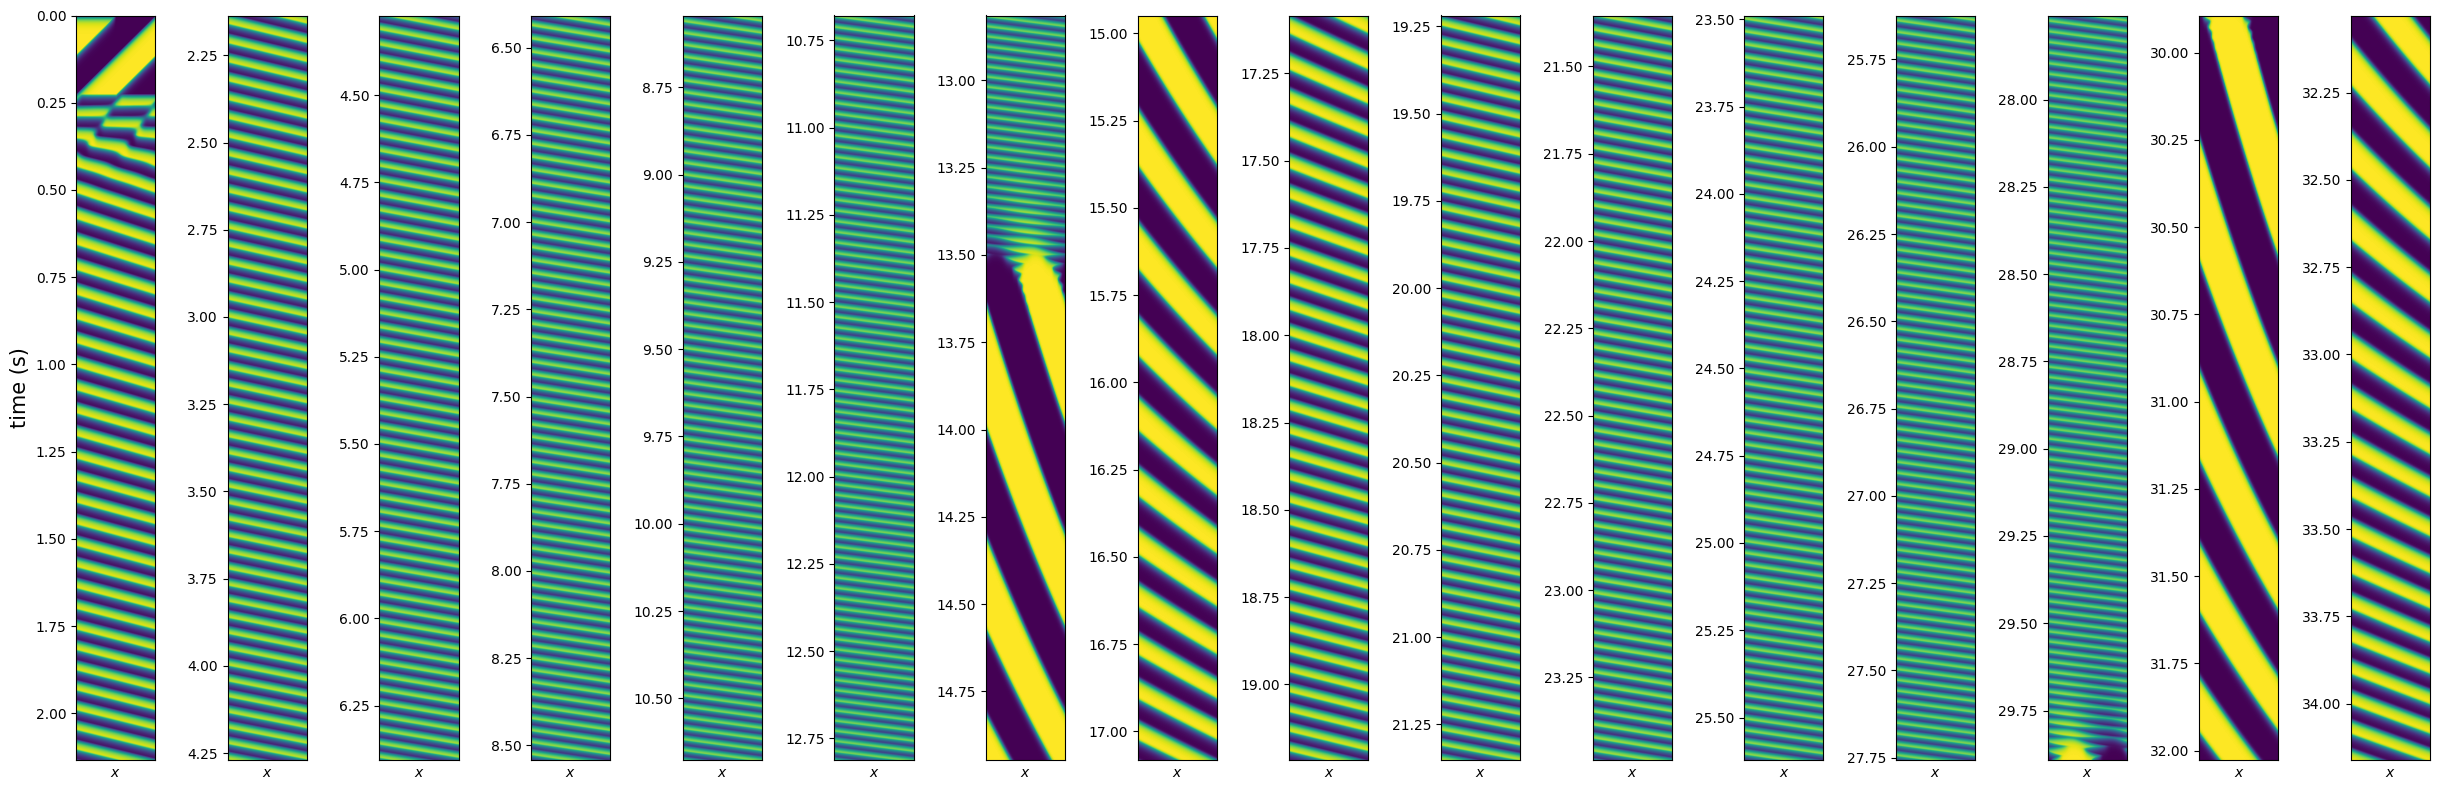

In [46]:
plot_activity(X, t, bins=16, cutoff_div=None)

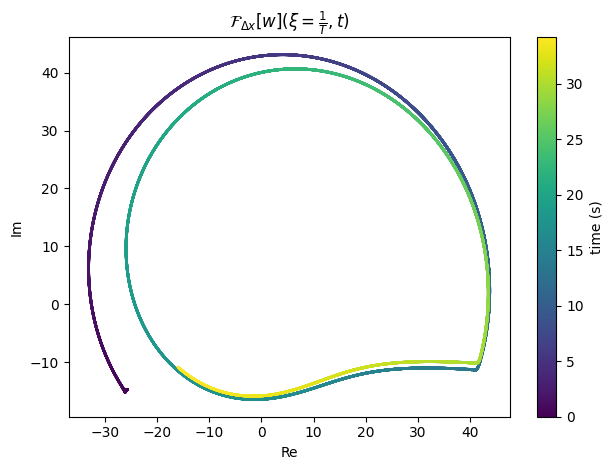

In [47]:
W_fft = np.fft.fft(W, axis=1)[:, 1]
scatter = plt.scatter(W_fft.real, W_fft.imag, c=t, s=1)
plt.title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
plt.xlabel('Re')
plt.ylabel('Im')
cbar = plt.colorbar(scatter)
cbar.set_label('time (s)')
plt.tight_layout()

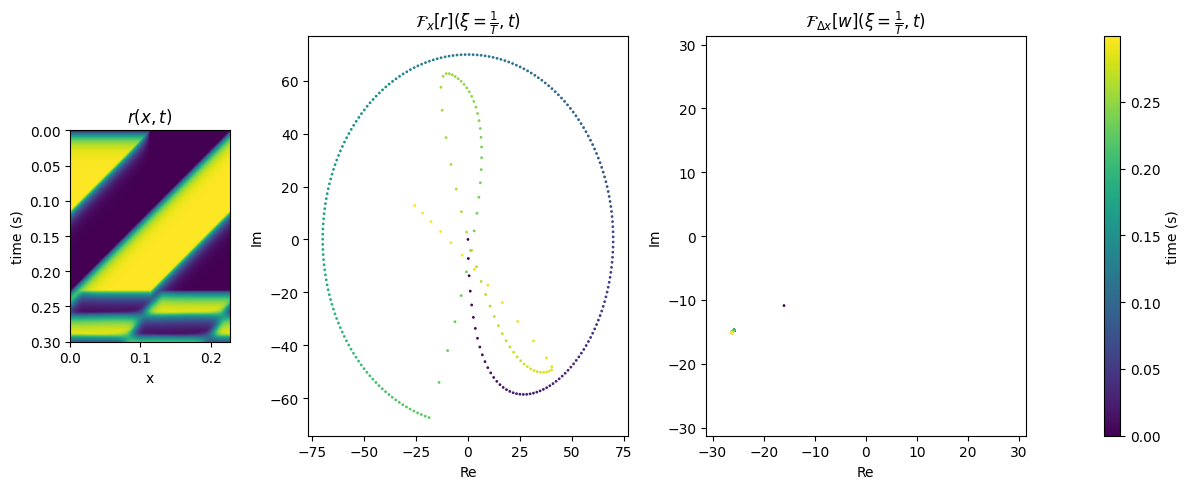

In [52]:
plot_system_segment(0, 300, X, W, t)

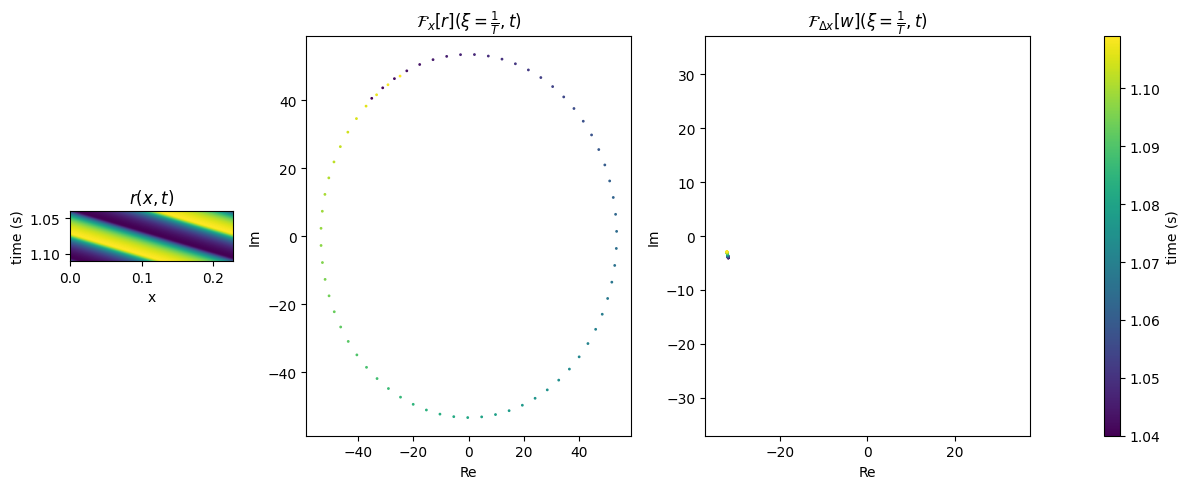

In [49]:
plot_system_segment(1040, 1110, X, W, t)

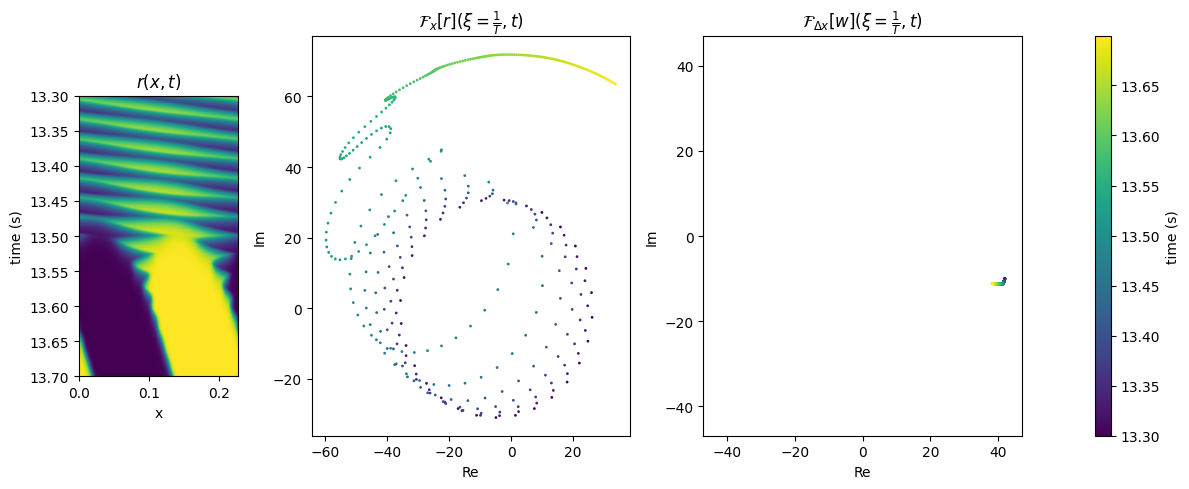

In [51]:
plot_system_segment(13300, 13700, X, W, t)

# flip-flopping

In [40]:
simulation_duration = 150.5 * T
t = np.arange(0, simulation_duration, dt)

tau_a = T / 10
delay_i = round(tau_a / dt)

tau_w = 50
beta = 1 / tau_w

In [41]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True)

CPU times: user 5.67 s, sys: 19.5 ms, total: 5.69 s
Wall time: 5.69 s


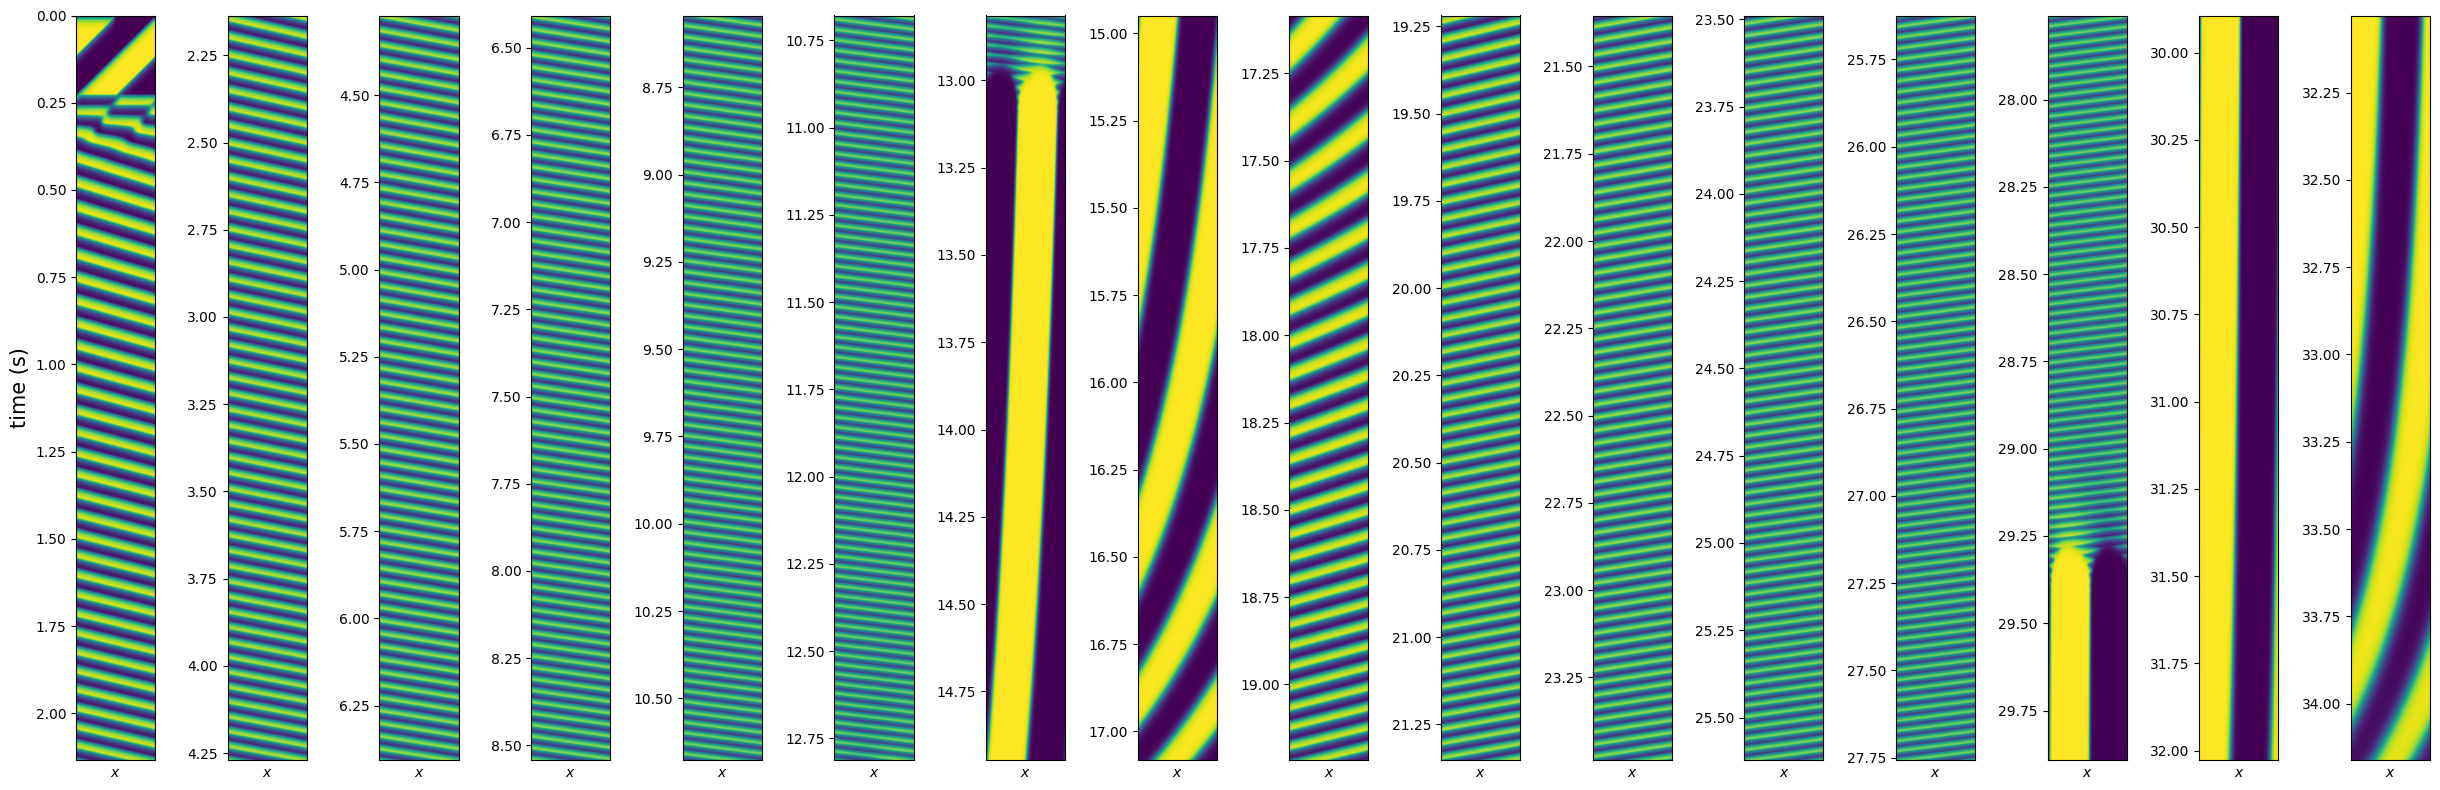

In [42]:
plot_activity(X, t, bins=16, cutoff_div=None)

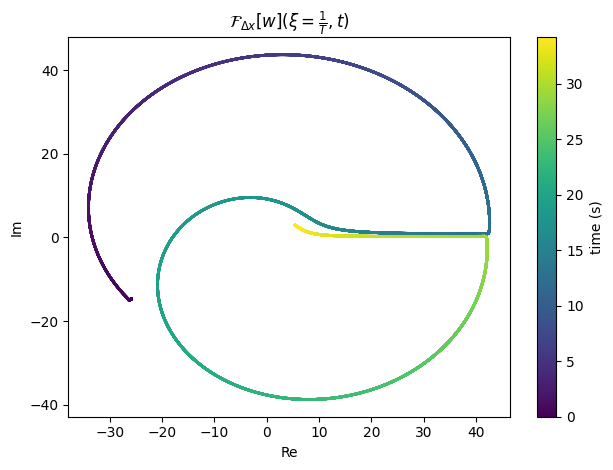

In [43]:
W_fft = np.fft.fft(W, axis=1)[:, 1]
scatter = plt.scatter(W_fft.real, W_fft.imag, c=t, s=1)
plt.title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
plt.xlabel('Re')
plt.ylabel('Im')
cbar = plt.colorbar(scatter)
cbar.set_label('time (s)')
plt.tight_layout()

# flip-flopping 2

In [35]:
simulation_duration = 150.5 * T
t = np.arange(0, simulation_duration, dt)

tau_a = T / 20
delay_i = round(tau_a / dt)

tau_w = 50
beta = 1 / tau_w

In [36]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True)

CPU times: user 5.62 s, sys: 29.1 ms, total: 5.65 s
Wall time: 5.65 s


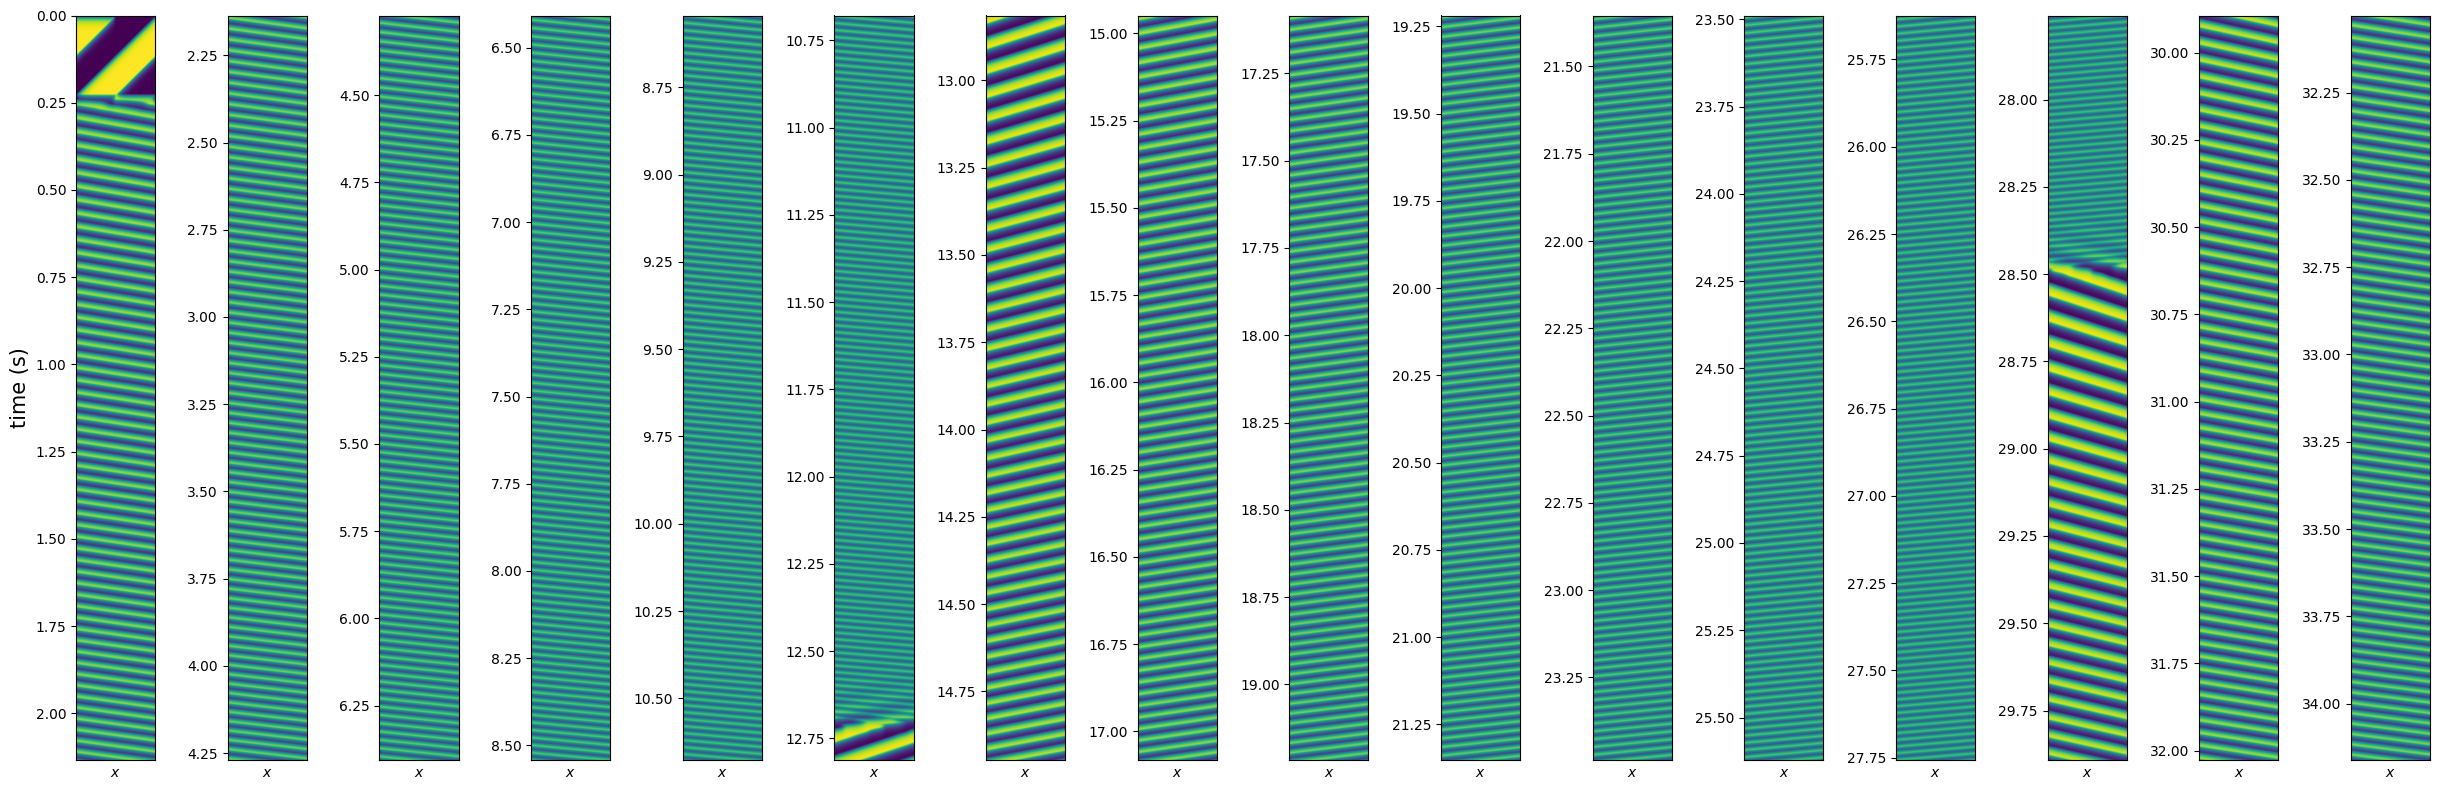

In [37]:
plot_activity(X, t, bins=16, cutoff_div=None)

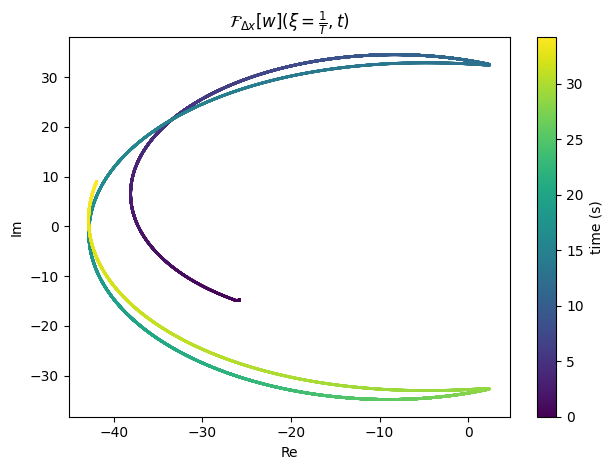

In [38]:
W_fft = np.fft.fft(W, axis=1)[:, 1]
scatter = plt.scatter(W_fft.real, W_fft.imag, c=t, s=1)
plt.title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
plt.xlabel('Re')
plt.ylabel('Im')
cbar = plt.colorbar(scatter)
cbar.set_label('time (s)')
plt.tight_layout()

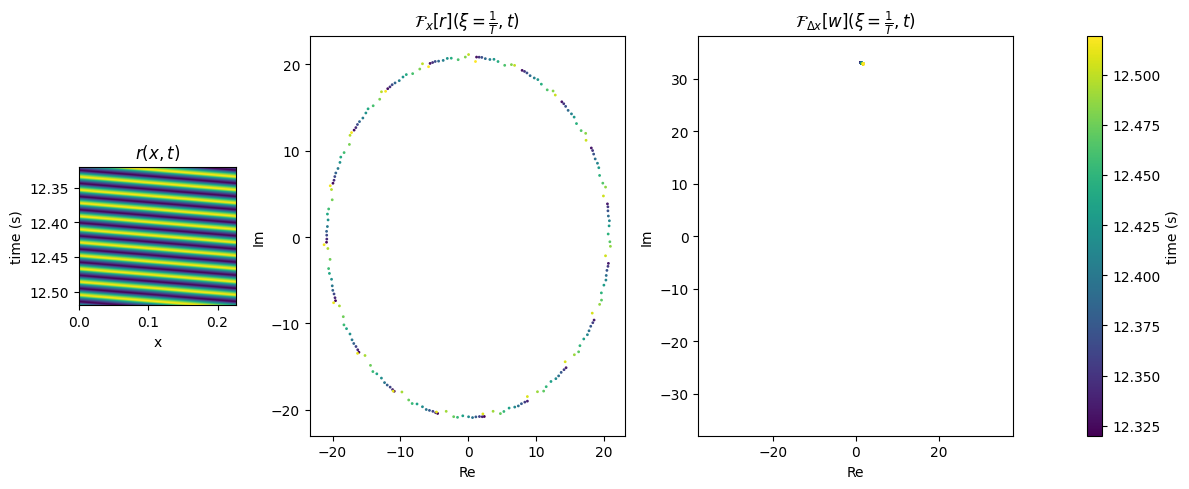

In [39]:
plot_system_segment(12320, 12520, X, W, t)

# strategy:

We approximate the dynamics of the system by the fundamental frequency components of $r$ and $w$. This results from the low-pass filtering properties of the rate dynamics.

1. determine $\frac{\partial}{\partial t} \theta_r = \frac{\partial}{\partial t}\text{arg}\Big(\mathcal{F}_{x}[r]\Big(\xi=\frac{1}{T}, t\Big)\Big)$ as a function of $\tau_d$, $\theta_w(t)$, $T$, $\theta_r(t-\tau_d)$
    - $\frac{\partial}{\partial t} \theta_r = \frac{\partial}{\partial t} \theta_{\frac{\partial r}{\partial t}} =\frac{\partial}{\partial t}\text{arg}\Big(\mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big) = \frac{\partial}{\partial t}\theta_{w}(t) + \frac{\partial}{\partial t}\theta_r(t-\tau_d)$
3. calculate $\omega_r(t)$ from $\frac{\partial}{\partial t} \theta_r$ and $T$
4. determine $\frac{\partial}{\partial t}\theta_w = \frac{\partial}{\partial t} \text{arg}\Big(\mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big)\Big)$ as a function of $\omega_r(t)$

already solved:

- $\frac{\partial}{\partial t} \theta_r = \frac{\partial}{\partial t} \theta_{\frac{\partial r}{\partial t}} =\frac{\partial}{\partial t}\text{arg}\Big(\mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)$
- $\text{arg}\Big(\mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big) = \theta_{w}(t) + \text{arg}\Big(\mathcal{F}_x[{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)$
    - $= \theta_{w}(t) + \text{arg}\Big({e^{-2\pi i \frac{\omega\tau_d}{T}}}\Big) + \theta_{r}(t)$ if replay is in same direction
    - $= \theta_{w}(t) - \text{arg}\Big({e^{-2\pi i \frac{\omega\tau_d}{T}}}\Big) + \theta_{r}(t)$ if replay is reversed
- $\text{arg}\Big(\mathcal{F}_{\Delta x}[\dot{r}(x, t) *' r(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big) = \text{arg}(i) - \text{arg}(e^{-2\pi i \frac{\omega\tau_d}{T}})$